In [154]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm

from utils import spectral_analysis
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

In [24]:
sns.set_context("paper")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 1

## Data Management

In [155]:
def make_sens_ts(dvdp,dvdq,n=274):
    """Make timeseries of sensitivity matrices"""
    assert dvdp.shape[0] == dvdq.shape[0]
    m_tot = dvdp.shape[0] #total measurments
    m = int(m_tot/n) #Timeseries interval
    svp,svq = [],[] #timeseries list of svp and svq matrices
    for t in range(m):
        svp.append(dvdp[t*n:(t+1)*n,:])
        svq.append(dvdq[t*n:(t+1)*n,:])
    return {'svp':svp,
            'svq':svq}

def make_deviations(data):
    """Make finite differences"""
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq))
    return (dx,dv)

def make_S_tilde(svp,svq):
    """Make wide S_tilde matrix"""
    return np.vstack((svp.T,svq.T)).T

def make_S_0(S_tilde,pct_obs):
    """Make initial observed matrix"""
    O,_ = constrained_linear_measurement_operator(S_tilde,pct_obs)
    O,S_0 = np.asarray(O),np.multiply(np.asarray(O),S_tilde)
    return O,S_0

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities

## 1. Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [151]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [152]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.09912479960769


In [89]:
imp.reload(mat_sens)
pf = 0.9*np.ones(S_tilde.shape[0])
K = mat_sens.K(pf)
sqv_impl = [svq_t@K for svq_t in svq]

### Solve the Matrix recovery problem with different levels of precomputed local coefficients

In [156]:
#imp.reload(mat_sens)
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
pct_obs_ = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.75] #Different levels of sensitivities already known to the utility
results = []
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    S_tilde = make_S_tilde(svp[0],svq[0])
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat.value,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 07:08:18 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 07:08:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 07:08:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 07:08:18 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 07:08:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 07:08:18 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 07:08:18 PM: Applying reduction CvxAttr2Constr
(CVXPY

0it [2:03:42, ?it/s]


AttributeError: 'dict' object has no attribute 'append'

In [161]:
mat_sens.calc_rel_err(S_hat.value,S_tilde)*100

81.6347566230062

Text(0.5, 1.0, '1% Observable Sensitivty Matrix (IEEE 123-bus)')

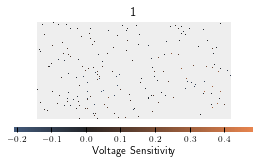

In [159]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

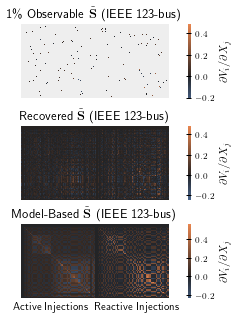

In [160]:
fig,axes = plt.subplots(nrows=3, 
                        figsize=(3.5,2*3.5/1.61828),
                        constrained_layout=True,
                        sharex=True, sharey=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
axes[0] = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=axes[0],
            linewidths=1e-6,
            cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}$  (IEEE 123-bus)")
#axes[0].set_title(r"{pct_obs:.0f}% Observable $\tilde{\mathbf{S}}$ (IEEE 123-bus)".format(pct_obs=pct_obs*100))
axes[1] = sns.heatmap(S_hat.value,ax=axes[1],
                      cmap=cmap,center=0,square=True,
                      xticklabels=False,yticklabels=False,
                      cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[1].set_title(r"Recovered $\tilde{\mathbf{S}}$ (IEEE 123-bus)")
axes[2] = sns.heatmap(S_tilde,ax=axes[2],
                      cmap=cmap,center=0,square=True,
                      xticklabels=False,yticklabels=False,
                     cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[2].set_title(r"Model-Based $\tilde{\mathbf{S}}$ (IEEE 123-bus)")
axes[2].set_xlabel(r"\ \ \ Active Injections \  Reactive Injections")
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/IEE123_recovery.01pct_lamb.125_delta.006.png",dpi=350)

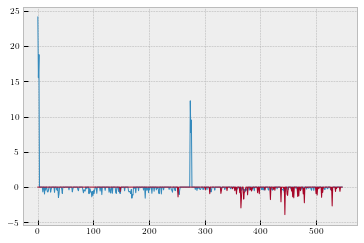

In [142]:
hat_dx = hat_dx_reg.coef_.T
plt.plot(dx[:,1])
plt.plot(hat_dx[:,1])

In [116]:
import utils
xhat = []
v_rel_err, x_rel_err, S_rel_err = [],[],[]

for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
    hat_dv_t = S_hat.value@dx_t
    S_tilde = make_S_tilde(svp[t],svq[t])
    x_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dx_t,v_true=dx_t)*100)
    S_rel_err.append(mat_sens.calc_rel_err(S_hat.value,S_tilde)*100)
    v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)



/home/sam/anaconda3/envs/mohca/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-02, tolerance: 2.081e-02
  model = cd_fast.enet_coordinate_descent(
/home/sam/anaconda3/envs/mohca/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e-02, tolerance: 2.081e-02
  model = cd_fast.enet_coordinate_descent(
/home/sam/anaconda3/envs/mohca/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

KeyboardInterrupt: 

Text(0.5, 1.0, 'Relative Complex Power Error $\\big(\\| \\boldsymbol{x}_t - \\hat{\\boldsymbol{x}}_t \\| \\big/ \\| \\boldsymbol{x}_t \\| \\big) \\times 100 $ (\\%)')

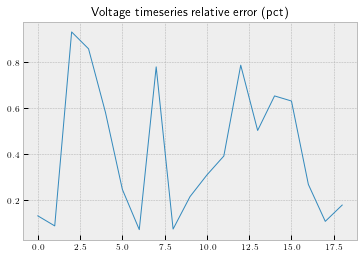

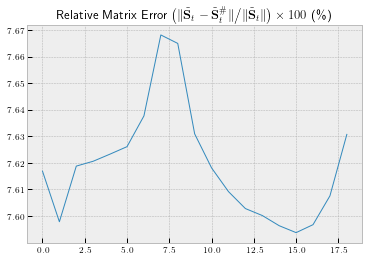

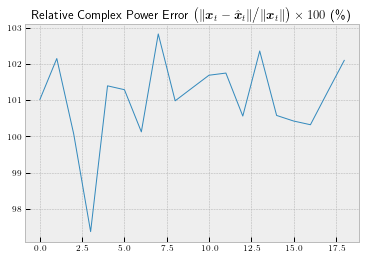

In [117]:
#Voltage relative error
plt.plot(v_rel_err)
plt.title("Voltage timeseries relative error (pct)")

#Sensitivity Matrix Relative Error
plt.figure()
plt.plot(S_rel_err)
plt.title(r"Relative Matrix Error $\big(\| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}_t^{\#} \| \big/ \| \tilde{\mathbf{S}}_t \| \big) \times 100 $ (\%)")

#Complex power relative error
plt.figure()
plt.plot(x_rel_err)
plt.title(r"Relative Complex Power Error $\big(\| \boldsymbol{x}_t - \hat{\boldsymbol{x}}_t \| \big/ \| \boldsymbol{x}_t \| \big) \times 100 $ (\%)")



In [118]:
dx_t.shape

(548,)

Text(0.5, 1.0, 'Sparsity of Injection Perturbations')

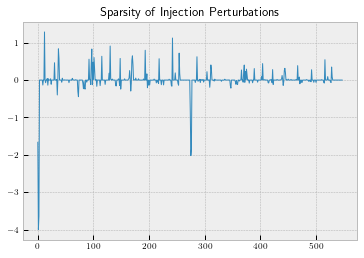

In [107]:
plt.plot(dx[:,7])
plt.title("Sparsity of Injection Perturbations")

In [108]:
S_rel_err[0]

7.616903027819162

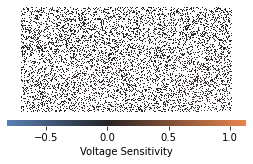

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

### Plot the Spectral Analysis for the IEEE 123 Test Feeder

In [100]:
cum_sigma,normed_sigma = spectral_analysis(S_tilde)

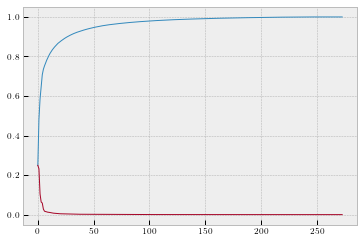

In [102]:
plt.plot(cum_sigma)
plt.plot(normed_sigma)

## 2. Synthetic demands, fixed power factor 

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)

## 3. Synthetic demands, varying power factor

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)